# **Rezbin AI Model v2.0 Development**

We are fine-tuning a MbileNet model for a multi-class image classification of the TrashNet dataset.

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader

Opening our TrashNet dataset via `datasets` from `torchvision`

In [2]:
from pathlib import Path

# opening dataset
dataset_path = Path('../dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

Splitting our dataset by 80% training, and 20% testing

In [3]:
from torch.utils.data import random_split
from torchvision.transforms import v2

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)
    
# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

Plotting Dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

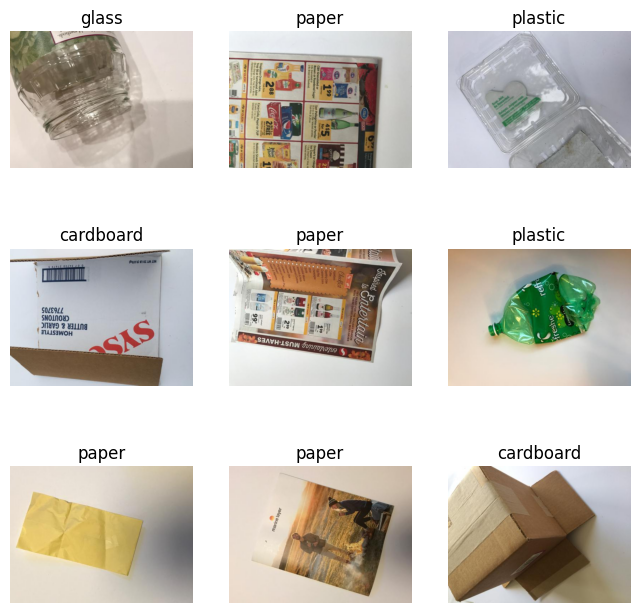

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

Let's define our basic preprocessing transformation pipeline, and plot it to see what it looks like. 

In [6]:
# defining transformation pipeline
transform = v2.Compose([
    # augmentation steps from paper
    v2.RandomAffine(
        degrees=5,
        translate=(0.2, 0.2),
        fill=0                     
    ),
    v2.RandomHorizontalFlip(),
    
    # Transform to image
    v2.Resize((256,256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [7]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].


Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


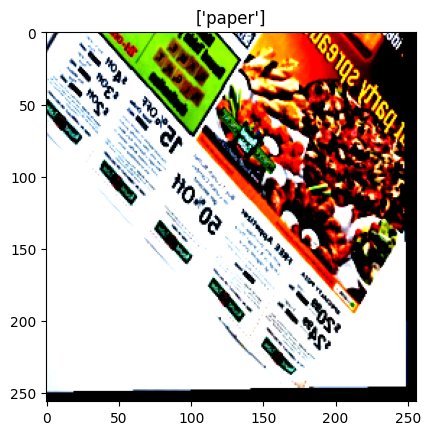

In [8]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0)) # permute cause image is already transformed by preprocessing pipeline
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [9]:
from torchvision import models
import torch.nn as nn
torch.cuda.empty_cache()
import os

In [10]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = models.mobilenet_v2(pretrained=True)


c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bonnie\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define Loss and Optimizer

In [12]:
import torch.optim as optim

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
import os
import torch
import torch.nn as nn

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)
model = model.to(device)

# === Load from checkpoint if available ===
checkpoint_path = '../models/01_mobilenetv2_finetuned.pth'
start_epoch = 0

if os.path.exists(checkpoint_path):
    print("✅ Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"✅ Loaded model weights from checkpoint")
    else:
        print("❌ Checkpoint does not contain 'model_state_dict'")
else:
    print("ℹ️ No checkpoint found. Training from scratch.")



✅ Loading checkpoint...
✅ Loaded model weights from checkpoint


Training MobileNet

In [14]:
from tqdm import tqdm
import os

num_epochs = 40

for epoch in range(start_epoch, start_epoch + num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Define save directory and path
    save_dir = '../models/'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, '01_mobilenetv2_finetuned.pth')

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_path)
        print(f"✅ Model saved to {save_path}")


100%|██████████| 32/32 [03:39<00:00,  6.87s/it]


Epoch [1/40], Loss: 0.1028, Accuracy: 96.78%


100%|██████████| 32/32 [03:09<00:00,  5.93s/it]


Epoch [2/40], Loss: 0.0968, Accuracy: 97.23%


100%|██████████| 32/32 [03:10<00:00,  5.95s/it]


Epoch [3/40], Loss: 0.0451, Accuracy: 98.22%


100%|██████████| 32/32 [03:08<00:00,  5.89s/it]


Epoch [4/40], Loss: 0.0772, Accuracy: 97.53%


100%|██████████| 32/32 [03:09<00:00,  5.92s/it]


Epoch [5/40], Loss: 0.0372, Accuracy: 98.86%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:09<00:00,  5.92s/it]


Epoch [6/40], Loss: 0.0321, Accuracy: 98.96%


100%|██████████| 32/32 [03:24<00:00,  6.38s/it]


Epoch [7/40], Loss: 0.0367, Accuracy: 98.76%


100%|██████████| 32/32 [03:08<00:00,  5.88s/it]


Epoch [8/40], Loss: 0.0495, Accuracy: 98.27%


100%|██████████| 32/32 [03:05<00:00,  5.80s/it]


Epoch [9/40], Loss: 0.0946, Accuracy: 96.88%


100%|██████████| 32/32 [03:06<00:00,  5.84s/it]


Epoch [10/40], Loss: 0.0646, Accuracy: 97.72%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:04<00:00,  5.76s/it]


Epoch [11/40], Loss: 0.0471, Accuracy: 98.52%


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [12/40], Loss: 0.0459, Accuracy: 98.52%


100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Epoch [13/40], Loss: 0.0386, Accuracy: 98.81%


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [14/40], Loss: 0.0420, Accuracy: 98.76%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [15/40], Loss: 0.0390, Accuracy: 98.76%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [16/40], Loss: 0.0587, Accuracy: 98.02%


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [17/40], Loss: 0.0352, Accuracy: 98.86%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [18/40], Loss: 0.0532, Accuracy: 97.97%


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [19/40], Loss: 0.0609, Accuracy: 98.27%


100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Epoch [20/40], Loss: 0.0447, Accuracy: 98.52%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Epoch [21/40], Loss: 0.0457, Accuracy: 98.52%


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [22/40], Loss: 0.0264, Accuracy: 99.21%


100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Epoch [23/40], Loss: 0.0414, Accuracy: 98.76%


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [24/40], Loss: 0.0728, Accuracy: 97.38%


100%|██████████| 32/32 [03:01<00:00,  5.67s/it]


Epoch [25/40], Loss: 0.0644, Accuracy: 98.02%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [26/40], Loss: 0.0522, Accuracy: 98.02%


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [27/40], Loss: 0.0467, Accuracy: 98.27%


100%|██████████| 32/32 [03:01<00:00,  5.67s/it]


Epoch [28/40], Loss: 0.0363, Accuracy: 98.76%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [29/40], Loss: 0.0333, Accuracy: 98.96%


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [30/40], Loss: 0.0297, Accuracy: 98.96%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [31/40], Loss: 0.0203, Accuracy: 99.26%


100%|██████████| 32/32 [03:01<00:00,  5.69s/it]


Epoch [32/40], Loss: 0.0152, Accuracy: 99.31%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [33/40], Loss: 0.0242, Accuracy: 99.11%


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [34/40], Loss: 0.0243, Accuracy: 99.26%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [35/40], Loss: 0.0408, Accuracy: 99.21%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Epoch [36/40], Loss: 0.0351, Accuracy: 98.71%


100%|██████████| 32/32 [03:01<00:00,  5.69s/it]


Epoch [37/40], Loss: 0.0253, Accuracy: 99.11%


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch [38/40], Loss: 0.0221, Accuracy: 99.21%


100%|██████████| 32/32 [03:02<00:00,  5.69s/it]


Epoch [39/40], Loss: 0.0339, Accuracy: 98.66%


100%|██████████| 32/32 [03:01<00:00,  5.67s/it]

Epoch [40/40], Loss: 0.0255, Accuracy: 99.31%
✅ Model saved to ../models/01_mobilenetv2_finetuned.pth


In [ ]:
# Evaluation
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 95.85%


: 